# 0. Libraries

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from lightgbm import LGBMClassifier
from matplotlib import patches
from scipy import stats
from scipy.stats import randint, uniform
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             confusion_matrix, precision_recall_curve, 
                             precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, log_loss)
from sklearn.model_selection import (KFold, RandomizedSearchCV, StratifiedKFold, 
                                     cross_val_score, train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine
from xgboost import XGBClassifier

# ---------- \ src Folder / ----------
main_dir = '/'.join(os.getcwd().split('/')[:-2])
sys.path.append(main_dir)

from src.data import hiden


# 1. EDA (Exploratory Data Analysis) 

## 1.1 Variables

In this section, I define a `var` dictionary to store key SQL connection details, including the table name and the database engine. I then retrieve all the data required for solving the Fraud Classification problem.

In [2]:
var = {
    
    'tablename': 'fraudclass',
    'engine': create_engine(hiden.alchemy(hiden.secrets())),
    
}

# Data DF
data = pd.read_sql_query(f"SELECT * FROM {var['tablename']}", con=var['engine'])

## 1.2 Support Functions

In this subsection, I define two utility functions to help analyze the distribution of unique values within a dataset. These functions provide insights into the data by summarizing counts and percentages of unique values. They are particularly useful for quickly identifying patterns and potential fraud cases within the data.

In [3]:
def count_unique(df, col):
    """
    Summarizes unique values in a DataFrame column with counts and percentages.

    Args:
        df: The input pandas DataFrame.
        col: The column name in the DataFrame for which unique values are summarized.

    Returns:
        A DataFrame with 'count' and 'percentage' columns for each unique value.
    """
    counts = df[col].value_counts()
    percentages = counts / len(df) * 100

    result = pd.DataFrame({
        'count': counts,
        'percentage': percentages
    })
    
    return result

def count_unique_fraud(data, col,sortby = 'count'):
    """
    Summarizes unique values and fraud statistics for a DataFrame column.

    Args:
        data: The input pandas DataFrame with a 'fraud' column indicating fraud cases.
        col: The column name to analyze unique values for.
        sortby: The column by which to sort the results, defaults to 'count'.

    Returns:
        A DataFrame with columns: 'count', 'percentage', 'fraud_count', 
        'fraud_percent_in_item', and 'fraud_percent_total'.
    """
    counts = data[col].value_counts()
    fraud_counts = data.groupby(col)['fraud'].sum()

    result = pd.DataFrame({
        'count': counts,
        'percentage': (counts / len(data)) * 100,
        'fraud_count': fraud_counts,
        'fraud_percent_in_item': (fraud_counts / counts) * 100,
        'fraud_percent_total': (fraud_counts / fraud_counts.sum()) * 100
    })
    
    return result.sort_values(by=sortby, ascending=False)




## 1.3 Looking At the Data

In [4]:
data.head()

,country,doc_sent_1,doc_sent_2,doc_sent_3,product,product_category,purchase_date,purchase_value,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,fraud,score_fraud_model
0,BR,1,None,N,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,2020-03-27 11:51:16,5.64,4,0.7685,94436.24,20.0,0.444828,1.0,5,0.883598,240.0,102.0,0,66
1,BR,1,Y,N,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,2020-04-15 19:58:08,124.71,4,0.7550,9258.50,1.0,0.000000,33.0,0,0.376019,4008.0,0.0,0,72
2,AR,1,None,N,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,2020-03-25 18:13:38,339.32,4,0.7455,242549.09,3.0,0.000000,19.0,23,0.516368,1779.0,77.0,0,95
3,BR,1,None,Y,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,2020-04-16 16:03:10,3.54,4,0.7631,18923.90,50.0,0.482385,18.0,23,0.154036,1704.0,1147.0,0,2
4,BR,1,None,N,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,2020-04-02 10:24:45,3.53,2,0.7315,5728.68,15.0,0.000000,1.0,2,0.855798,1025.0,150.0,0,76


### 1.3.1 Missing values

This section focuses on visualizing missing values in the dataset. Two key visualizations are used:
1. A heatmap that highlights the location of missing values across the entire DataFrame.
2. A bar chart that displays the percentage of missing values for each column.

These visualizations provide a clear overview of where data is missing, helping to assess the extent of the issue and guide data cleaning efforts.

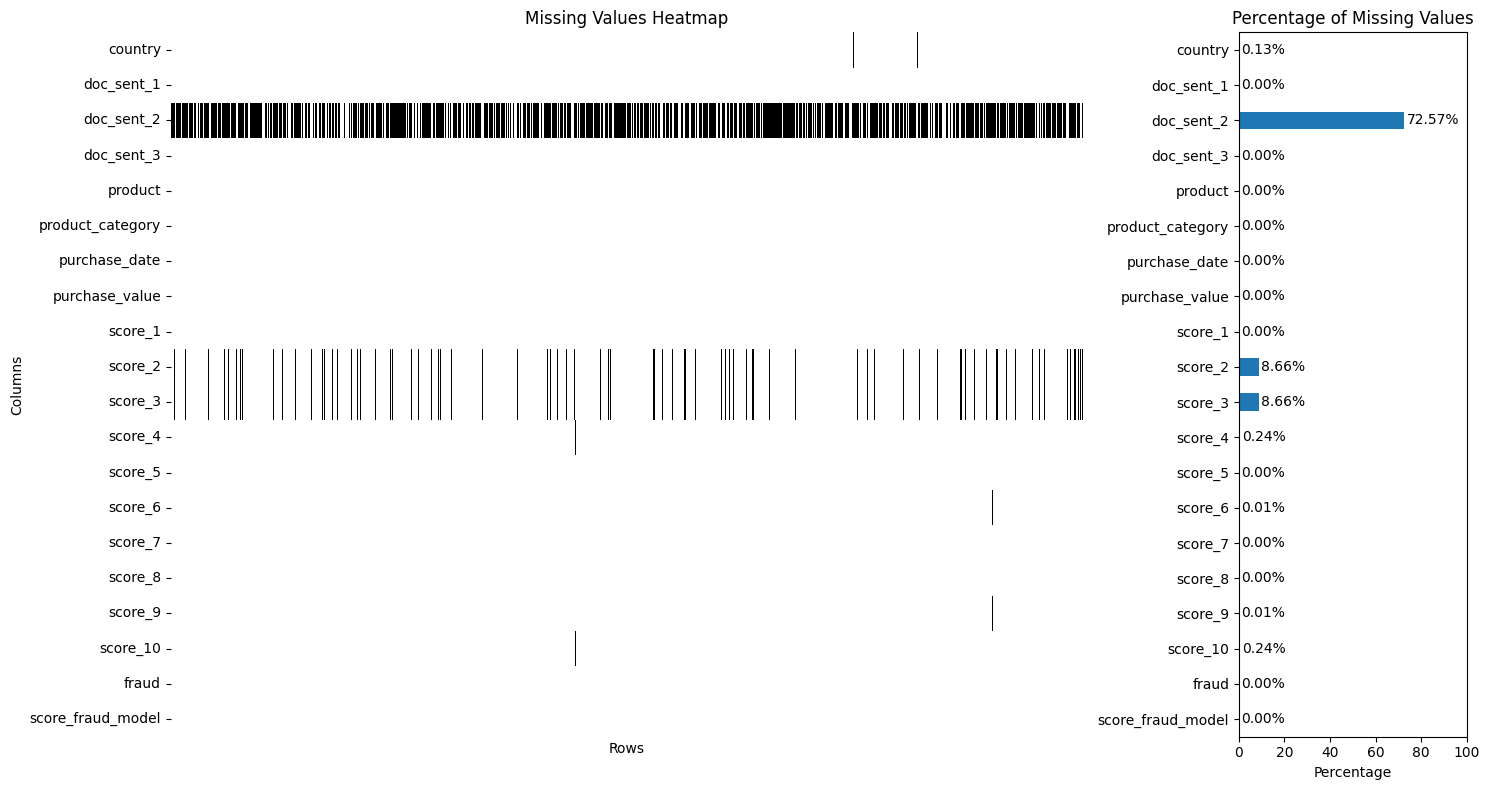

In [5]:
def plot_missing_data(data):
    """
    Visualizes missing data in a DataFrame by generating a heatmap and a bar chart
    of the percentage of missing values for each column.

    Args:
        data: The input pandas DataFrame containing missing values.

    Returns:
        None. The function displays two plots:
        - A heatmap indicating missing values across the DataFrame.
        - A horizontal bar plot showing the percentage of missing values for each column.
    """

    # Create a boolean mask of missing values
    missing_mask = data.isnull()

    # Calculate the percentage of missing values for each column
    missing_percentage = missing_mask.mean().round(4) * 100

    # Set up the matplotlib figure
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})

    # Heatmap
    sns.heatmap(missing_mask.T, cbar=False, cmap='binary', ax=ax1)

    ax1.set_title('Missing Values Heatmap')
    ax1.set_xlabel('Rows')
    ax1.set_ylabel('Columns')
    ax1.set_xticks([])  # Hide x-axis ticks

    # Horizontal bar plot for missing percentages
    missing_percentage.plot(kind='barh', ax=ax2)
    ax2.set_title('Percentage of Missing Values')
    ax2.set_xlabel('Percentage')
    ax2.set_xlim(0, 100)  # Set x-axis limit from 0 to 100%

    for i, v in enumerate(missing_percentage):
        ax2.text(v + 1, i, f'{v:.2f}%', va='center')

    ax2.invert_yaxis() # Invert y-axis of the percentage plot to match the order of the heatmap

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_missing_data(data)

The column `doc_sent_2` has over 70% missing data. Since this column relates to document submission, it is reasonable to infer that the missing entries indicate that the consumer did not submit the required document. Additionally, both `score_2` and `score_3` exhibit missing data in the same locations, suggesting a potential correlation between these two columns. This pattern could indicate a shared data issue or a relationship that may need further exploration.

## 1.4 Uni and Bivariate Analysis

In this section, I will analyze each column to determine whether to remove or modify it. This will help me create a cleaner and more usable dataset.

### 1.4.1 Country

First, I’ll examine the `country` column to understand how many distinct countries are represented in the dataset. Additionally, I’ll explore how fraudulent activities are distributed across these countries to assess any patterns related to this feature.

In [6]:
dftemp = count_unique_fraud(data,'country',sortby = 'count')
print(f'Number of Countries = {len(dftemp)}')
dftemp.head(20)

Number of Countries = 51


,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total
country,,,,,
BR,111628,74.418667,6162,5.520120,82.324649
AR,31964,21.309333,1179,3.688525,15.751503
UY,2967,1.978000,29,0.977418,0.387442
US,2273,1.515333,70,3.079630,0.935204
SE,358,0.238667,15,4.189944,0.200401
MX,236,0.157333,3,1.271186,0.040080
RU,73,0.048667,6,8.219178,0.080160
ES,69,0.046000,5,7.246377,0.066800
CO,64,0.042667,1,1.562500,0.013360


Approximately 95% of all transactions occur in Brazil (BR) and Argentina (AR). To simplify the dataset and improve the performance of machine learning models, I will combine all other countries into a new category called "OTHER." This approach reduces complexity, minimizes the risk of overfitting to rare cases, and enhances the efficiency and interpretability of the models.

In [7]:
def change_countries(data):
    df = data.copy()
    df.loc[~data['country'].isin(['BR', 'AR']),'country'] = 'OTHER'
    
    dftemp = count_unique_fraud(df,'country',sortby = 'count')
    display(dftemp)

change_countries(data)

,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total
country,,,,,
BR,111628,74.418667,6162,5.520120,82.16
AR,31964,21.309333,1179,3.688525,15.72
OTHER,6408,4.272000,159,2.481273,2.12


The fraud rates for Brazil (BR), Argentina (AR), and the grouped "OTHER" category are relatively close: 5.5%, 3.7%, and 2.5%, respectively. This suggests that the countries combined into "OTHER" do not exhibit significantly different fraud patterns compared to Brazil and Argentina. As a result, merging these countries into a single category does not distort the fraud detection analysis. Instead, it simplifies the dataset while maintaining the overall structure and ensuring that meaningful insights from smaller markets are preserved. This also helps to reduce noise and prevent overfitting during model training.


### 1.4.2 Documents

In this part of the analysis, I transform the document submission columns to Boolean values in order to better understand the proportions between submitted (`True`) and non-submitted (`False`) documents. All instances of missing values (`NaN`) or `N` (representing non-submission) are replaced with `False`, while `Y` (indicating submission) is replaced with `True`. This transformation simplifies the analysis by making the document submission data easier to interpret and compare.

In [8]:
def to_bool_series(data,col):
    series = data[col].copy()
    series = series.astype('object')

    true_mask = series.isin(['Y', 1])
    false_mask = (series.isna()) | series.isin(['N', 0])

    series[true_mask] = True
    series[false_mask] = False   

    return series.astype('bool')


def checkdocs(data):
    df = data.copy()
    doc_cols = df.filter(like='doc_sent_').columns

    doc_cols = [col for col in df.columns if 'doc_sent_' in col]
    df[doc_cols] = df[doc_cols].apply(lambda col: to_bool_series(df, col.name))

    # Print fraud statistics for each modified 'doc_sent_' column
    for docname in doc_cols:
        display(count_unique_fraud(df, docname, sortby=docname))
        print('-' * 50)

checkdocs(data)

,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total
doc_sent_1,,,,,
True,135353,90.235333,5140,3.797478,68.533333
False,14647,9.764667,2360,16.112515,31.466667


--------------------------------------------------


,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total
doc_sent_2,,,,,
True,24091,16.060667,1554,6.450542,20.72
False,125909,83.939333,5946,4.722458,79.28


--------------------------------------------------


,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total
doc_sent_3,,,,,
True,83129,55.419333,2421,2.912341,32.28
False,66871,44.580667,5079,7.595221,67.72


--------------------------------------------------


### 1.4.3 Products

In this step, I analyze the distribution of products and product categories within the dataset. By examining the frequency of each product and its associated category, I can better understand the representation of different items and their groupings.


In [9]:
def column_vcounts(data, columns):
    """
    Prints the value counts of specified columns in the given DataFrame, separated by a line of dashes.

    Args:
        data (pd.DataFrame): The DataFrame containing the specified columns.
        columns (list): A list of column names to print value counts for.
    """
    for column in columns:
        series = data[column].value_counts()
        display(series)
        print(f"{'-'*50}")

column_vcounts(data, ['product','product_category'])

product
Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Instalamos Os Mods De Minecraft Para Você                        1
Controle Remoto Guincho Elétrico 12v                             1
Playstation 4 Ps4 Slim 500gb Original + Controle + Fifa 19       1
Kit Wella Fusion Shampoo 1 Litro Máscara 500ml                   1
2 Potes Moder Diet 500mg 100caps Total 200caps                   1
Name: count, Length: 127804, dtype: int64

--------------------------------------------------


product_category
cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
               ... 
cat_f8324ca       1
cat_d6c71e0       1
cat_34ac07c       1
cat_4858280       1
cat_be3757f       1
Name: count, Length: 8324, dtype: int64

--------------------------------------------------


The "product" column has a very high cardinality, meaning it contains too many unique values. This can introduce unnecessary complexity into the machine learning model, potentially slowing down processing and impacting performance. For this reason, I will remove the "product" column.

Although the "product_category" column also has high cardinality, it is about 15 times smaller than the "product" column. Additionally, since both columns provide similar information, I will retain "product_category" for the analysis. To further reduce cardinality and improve the quality of the analysis, a more advanced approach could involve using a language model to group products into fewer, more general categories. However, for simplicity, I will address the cardinality issue by focusing only on categories with higher instances of fraud.

,count,percentage,fraud_count,fraud_percent_in_item,fraud_percent_total,fraud_percent_cumsum
product_category,,,,,,
cat_43b9c10,2331,1.554000,380,16.302016,5.066667,5.066667
cat_d69bed9,1799,1.199333,54,3.001668,0.720000,5.786667
cat_604df77,1784,1.189333,71,3.979821,0.946667,6.733333
cat_6c4cfdc,1449,0.966000,74,5.106970,0.986667,7.720000
cat_4249bd8,1191,0.794000,98,8.228380,1.306667,9.026667
...,...,...,...,...,...,...
cat_b8984b3,1,0.000667,0,0.000000,0.000000,100.000000
cat_b902482,1,0.000667,0,0.000000,0.000000,100.000000
cat_b9156af,1,0.000667,0,0.000000,0.000000,100.000000


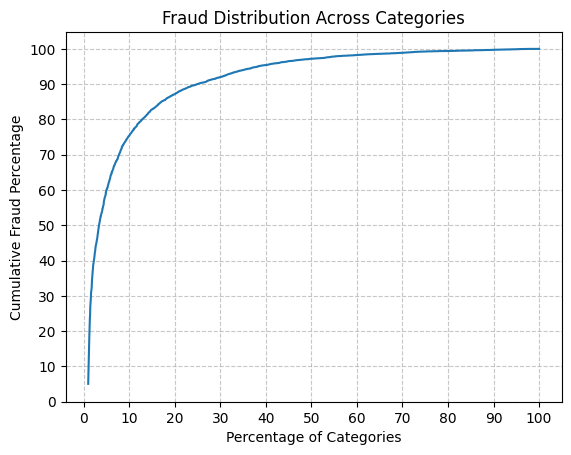

80% of fraud cases occur in about 12% (996) of the top selling product categories


In [10]:
def fraud_distribution(data, category_column='product_category', threshold=80):
    """
    Plots cumulative sum of fraud cases by category and calculates the percentage of fraud cases in top categories.

    Args:
        data (pd.DataFrame): The DataFrame containing fraud data.
        category_column (str, optional): Column name for product categories, default is 'product_category'.
        threshold (int, optional): Percentage threshold for identifying top categories contributing to fraud, default is 80%.
    """
    dftemp = count_unique_fraud(data, category_column, sortby='count')
    fraud_cumsum = dftemp['fraud_percent_total'].cumsum()
    dftemp['fraud_percent_cumsum'] = fraud_cumsum
    
    category_percent = np.linspace(1, 100, len(fraud_cumsum))
    top_categories_percent = len(fraud_cumsum[fraud_cumsum <= threshold]) / len(fraud_cumsum) * 100
    
    # Displays
    display(dftemp)
    
    # PLot
    plt.plot(category_percent, fraud_cumsum)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(np.arange(0, 110, 10))
    plt.yticks(np.arange(0, 110, 10))
    
    plt.xlabel('Percentage of Categories')
    plt.ylabel('Cumulative Fraud Percentage')
    plt.title('Fraud Distribution Across Categories')
    
    plt.show()
    
    # Prints
    print(f"{threshold}% of fraud cases occur in about {round(top_categories_percent)}% ({len(fraud_cumsum[fraud_cumsum <= threshold])}) "
          f"of the top selling product categories")

fraud_distribution(data)

The analysis shows that around 80% of fraud cases are concentrated in approximately 12% of the top-selling product categories. This highlights that a small portion of product categories accounts for the majority of fraud. To streamline the dataset and focus on the most relevant data, I will exclude the remaining categories that contribute little to overall fraud detection. By narrowing the scope to these key categories, I can improve model efficiency while maintaining the ability to capture significant fraud patterns.

### 1.4.4 Purchase Information

Initially, the purchase date could be transformed into two new columns: "Day of the Week" and "Periods of the Day" (Morning, Afternoon, Evening, Night). However, using the date as a feature in this dataset may lead to predictable patterns that could be exploited by fraudsters. For this reason, I have decided to exclude the purchase date from the analysis moving forward.

Next, I analyzed the distribution of purchase values to explore their relationship with fraudulent transactions. By dividing purchase values into ranges, I aimed to identify patterns or trends that may indicate a higher likelihood of fraud based on the transaction amount. This analysis helps uncover whether certain purchase value ranges are more prone to fraudulent activity, providing insights for further fraud detection improvements.

Description fo the purchase_values


count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: purchase_value, dtype: float64

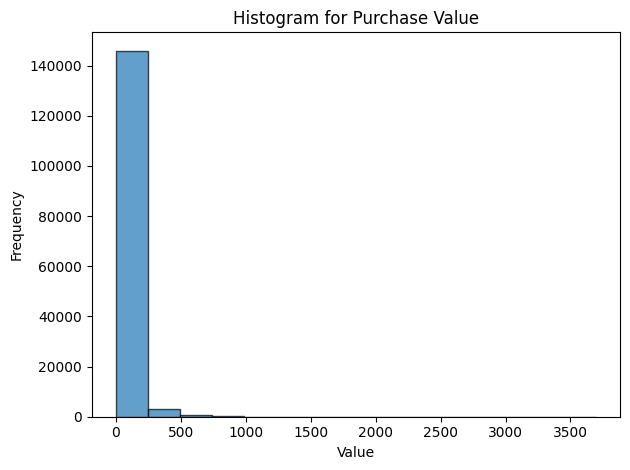

--------------------------------------------------
purchase_value vs fraud


,count,count_sum_percent,fraud_count,fraud_sum_percent,fraud_percent,fraud_percent_total
range,,,,,,
0-50,120793,80.53,5351,71.35,4.43,71.35
50-100,16492,91.52,962,84.17,5.83,12.83
100-150,4649,94.62,304,88.23,6.54,4.05
150-200,2471,96.27,198,90.87,8.01,2.64
200-250,1667,97.38,164,93.05,9.84,2.19
...,...,...,...,...,...,...
3450-3500,0,100.00,0,100.00,0.00,0.00
3500-3550,1,100.00,0,100.00,0.00,0.00
3550-3600,0,100.00,0,100.00,0.00,0.00


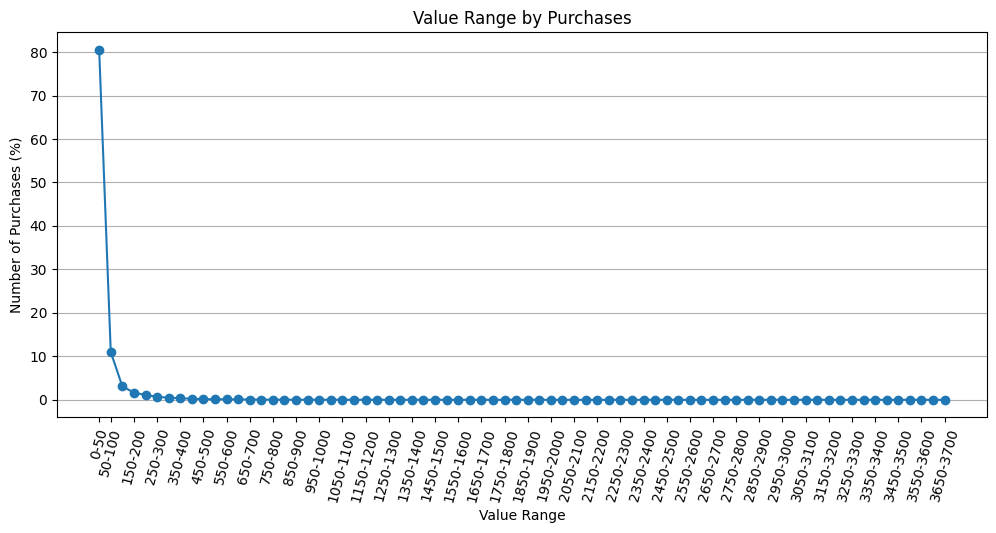

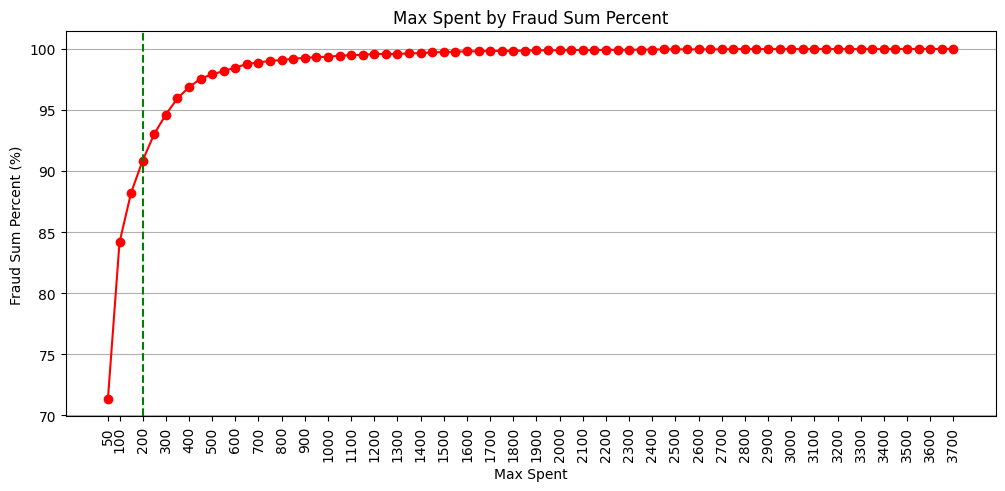

In [11]:
def analyze_purchase_fraud(data):

    purchase_values = data['purchase_value']
    fraud_total = data['fraud'].sum()

    summary_stats = []    
    countsum, fraudsum = 0, 0
    
    bin_size = 50
    max_value = (int(np.max(purchase_values) // bin_size) + 2) * bin_size
    
    for x0, x1 in zip(range(0, max_value-bin_size, bin_size), range(bin_size, max_value, bin_size)):
        name = f"{x0}-{x1}"

        df_range = data[(purchase_values > x0) & (purchase_values <= x1)]
        count, fraud_count = len(df_range), df_range['fraud'].sum()

        countsum += count
        fraudsum += fraud_count

        summary_stats.append({
            'range': name,
            'max_spent': x1,

            'count': count,
            'percentage': 100 * count / len(purchase_values),
            'count_sum_percent': round(100 * countsum / len(purchase_values),2),

            'fraud_count': fraud_count,
            'fraud_sum_percent': round(100 * fraudsum / fraud_total if fraud_total else 0,2),
            'fraud_percent': round(100 * fraud_count / count if count else 0,2),
            'fraud_percent_total': round(100 * fraud_count / fraud_total if fraud_total else 0,2),
        })
        

    df_summary = pd.DataFrame(summary_stats).set_index('range')
    df_summary_simple = df_summary.drop(columns=['max_spent', 'percentage'])

    print("Description fo the purchase_values")
    display(purchase_values.describe())
    plot_hist_purcvalue(purchase_values)
    
    print(f"{'-'*50}\npurchase_value vs fraud")
    display(df_summary_simple)

    plot_spent_vs_percentage(df_summary)
    plot_spent_vs_fraud_sum(df_summary,200)

def plot_hist_purcvalue(series):
    plt.hist(series, bins=15, edgecolor='black', alpha=0.7)
    plt.title('Histogram for Purchase Value')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_spent_vs_percentage(df):
    
    index_list = df.index.tolist()
    plt.figure(figsize=(12, 5))
    plt.plot(index_list, df['percentage'], marker='o')
    plt.title('Value Range by Purchases')
    plt.xlabel('Value Range')
    plt.ylabel('Number of Purchases (%)')
    plt.grid(True, axis='y')
    
    xticks = np.array([50]+list(range(100, max(df['max_spent']) + 1, 100)))/50-1
    xticks = [x for i,x in enumerate(index_list) if i in xticks]

    plt.xticks(ticks=xticks, rotation=75)
    plt.show()

def plot_spent_vs_fraud_sum(df,x_value):
    plt.figure(figsize=(12, 5))
    plt.plot(df['max_spent'], df['fraud_sum_percent'], marker='o', color='red')
    plt.title('Max Spent by Fraud Sum Percent')
    plt.xlabel('Max Spent')
    plt.ylabel('Fraud Sum Percent (%)')
    plt.grid(True, axis='y')
    xticks = [50]+list(range(100, max(df['max_spent']) + 1, 100))

    plt.xticks(ticks=xticks, rotation=90)

    # Highlight the fourth value with a vertical line
    plt.axvline(x=x_value, color='green', linestyle='--')

    plt.show()

analyze_purchase_fraud(data)

As shown above, approximately 96% of transactions under $200 account for 90% of all fraud cases. This indicates that the vast majority of fraudulent activity occurs in lower-priced purchases. However, to gain a more complete understanding, we need to explore how much money is lost due to fraud in higher-priced items. This will help assess whether high-value fraud cases, despite being less frequent, contribute significantly to the total amount of money lost to fraud.

In [12]:
def summarize_sales_loss(data, n=200):
    """
    Summarizes and prints money lost in fraudulent sales, categorized below or above a specified threshold.

    Args:
        data (DataFrame): The dataset containing information about sales and fraud status.
        n (int, optional): The threshold value used to split the sales. Defaults to 200.
    
    Raises:
        ZeroDivisionError: If there are no fraudulent sales and the total lost money (`lm`) is zero.
    """
    lm = data[data['fraud'] == 1]['purchase_value'].sum()
    lmb = data[(data['fraud'] == 1) & (data['purchase_value'] <= n)]['purchase_value'].sum()
    lma = data[(data['fraud'] == 1) & (data['purchase_value'] > n)]['purchase_value'].sum()

    if lm == 0:
        print("No fraudulent sales found.")
        return

    print("Money lost in sales")
    print(f" - below ${n:0.2f}: ${lmb:0.2f} ({100 * lmb / lm:0.2f}%)")
    print(f" - above ${n:0.2f}: ${lma:0.2f} ({100 * lma / lm:0.2f}%)")

summarize_sales_loss(data)


Money lost in sales
 - below $200.00: $241140.18 (44.06%)
 - above $200.00: $306130.94 (55.94%)


Although only 4% of the sales are over $200, fraud in these transactions accounts for 56% of the total financial losses. This indicates that even though fraud is more frequent in lower-priced sales, the financial impact of fraud in higher-priced sales is significantly larger. This insight highlights the importance of also targeting fraud prevention efforts on higher-value transactions to reduce the overall financial loss.

### 1.4.5 Frauds

In this section, I analyze the distribution of fraudulent transactions within the dataset. I have chosen to exclude the "score_fraud_model" column from the analysis, as it contains prior model predictions, which are not relevant to the current evaluation.


In [13]:
df = count_unique(data,'fraud')
df.head()

,count,percentage
fraud,,
0,142500,95.0
1,7500,5.0


As expected in a fraud detection problem, the dataset is highly imbalanced, with only 5% of transactions classified as fraudulent. This significant imbalance can pose challenges for machine learning models, as they may struggle to correctly identify the minority class (fraud). To ensure the model can effectively detect fraudulent transactions, this imbalance will be addressed in the modeling phase.


### 1.4.6 Scores (Unknown Variables)

The `score_1` to `score_10` columns represent unknown variables, and their distribution can be explored through histograms. The goal is to uncover potential patterns or relationships within the dataset, even though the exact meaning of these scores is unclear. Understanding their distribution may provide insights for fraud detection or help with feature engineering in future stages of the analysis.

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000


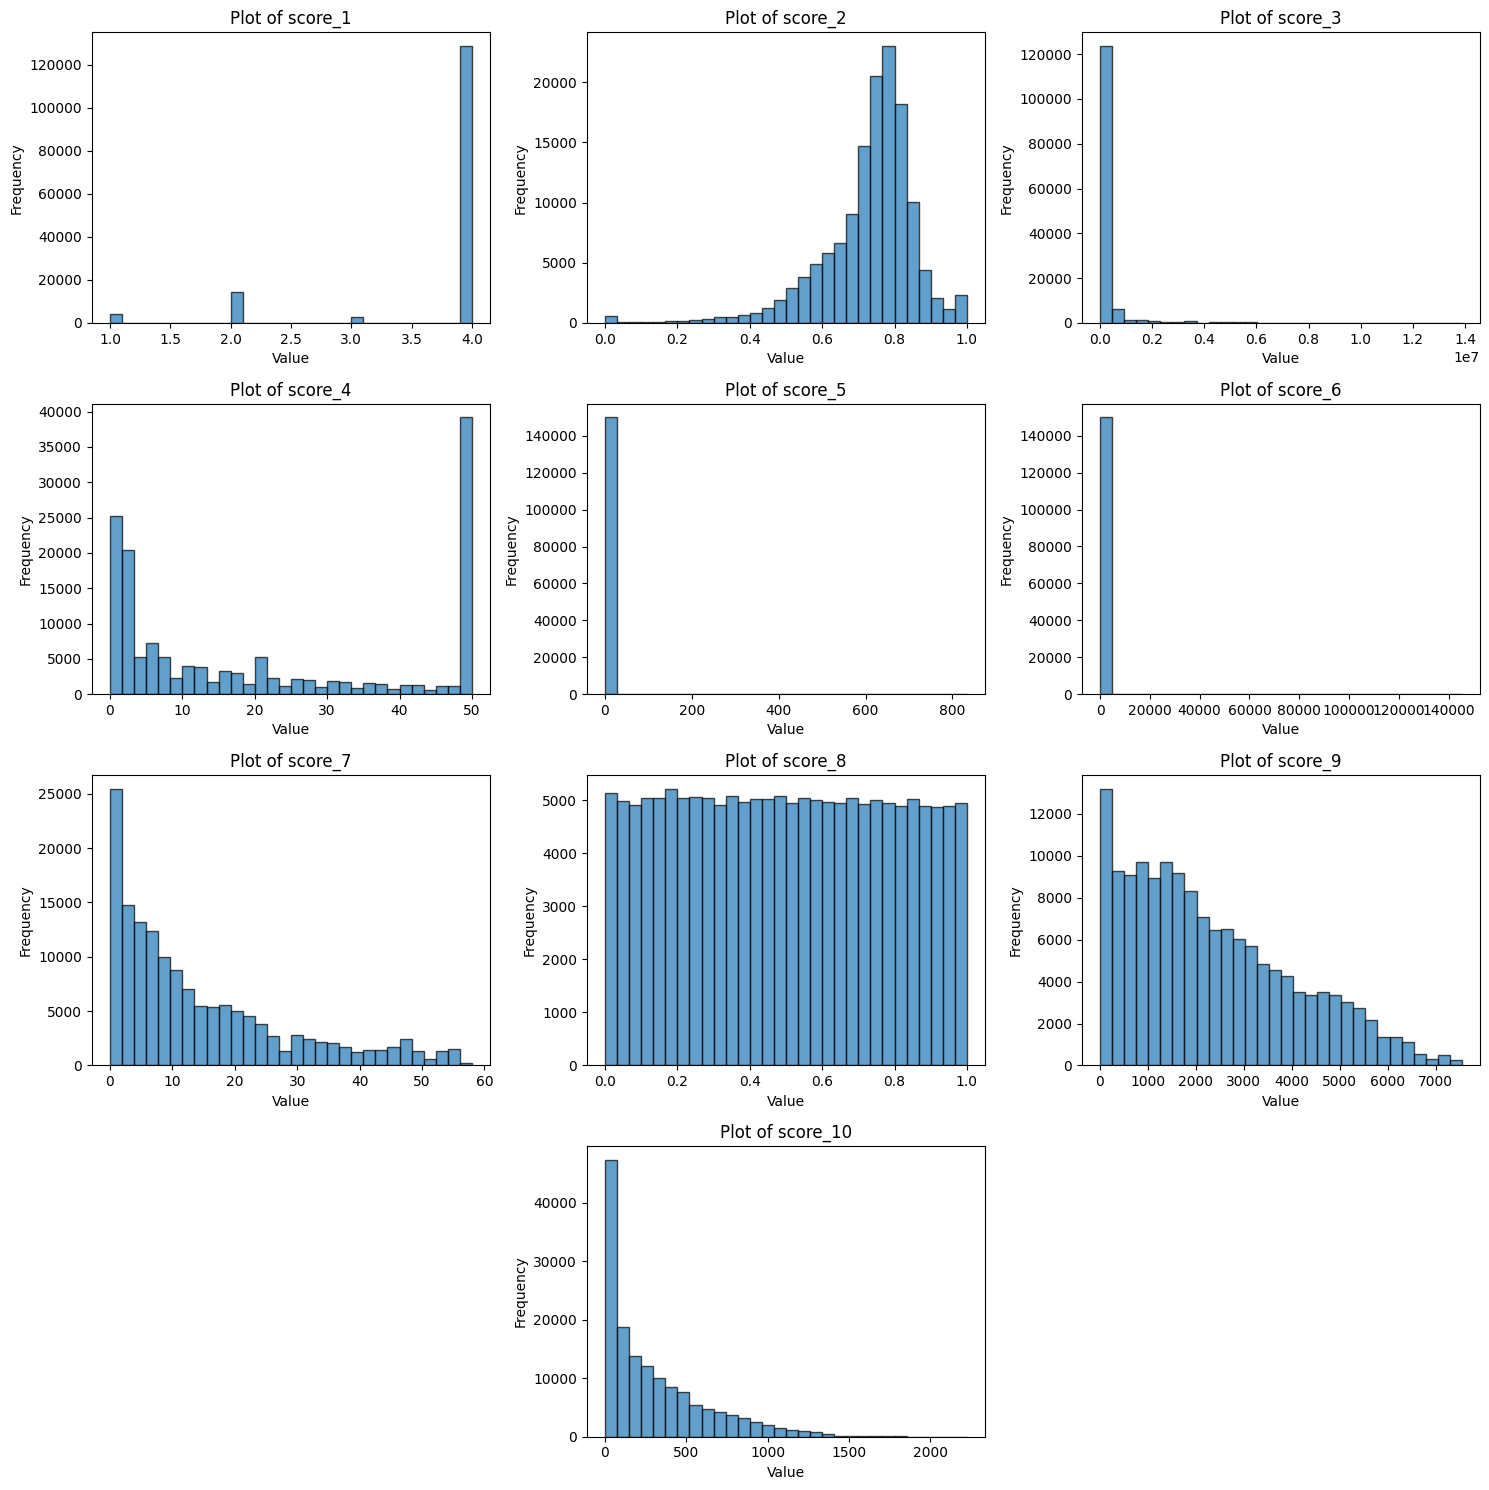

In [14]:
def plot_scores(data, plot_type='scatter'):
    """
    Creates a 4x3 grid of scatter plots or histograms for the columns `score_1` to `score_10` in the `data` DataFrame.
    The plot type can be either 'scatter' or 'hist'. Empty subplots are removed, and custom x-ticks are added for scatter plots.

    Args:
        data (DataFrame): The dataset containing the columns `score_1` to `score_10`.
        plot_type (str, optional): The type of plot to create ('scatter' or 'hist'). Defaults to 'scatter'.

    Raises:
        ValueError: If `plot_type` is not 'scatter' or 'hist'.
        KeyError: If any of the specified `score` columns are missing from `data`.
    """
    if plot_type not in ['scatter', 'hist']:
        raise ValueError("Invalid plot_type. Choose either 'scatter' or 'hist'.")

    # Create a figure with 10 subplots (4 rows, 3 columns)
    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    axs = axs.flatten()

    # List of column names
    columns = [f'score_{i}' for i in range(1, 11)]

    # Plot each column in a separate subplot
    for i, column in enumerate(columns):
        if column == 'score_10':
            i = 10  # Ensure 'score_10' goes to the right subplot

        if plot_type == 'scatter':
            # Scatter plot for each score column
            axs[i].scatter(data.index, data[column], alpha=0.5)
            axs[i].set_title(f'Plot of {column}')
            axs[i].set_xlabel('Index')
            axs[i].set_ylabel('Value')

            # Set xticks to display 5 evenly spaced ticks
            x_ticks = np.linspace(data.index.min() + 1, data.index.max() + 1, 5)
            axs[i].set_xticks(x_ticks)
            axs[i].set_xticklabels([f'{x:.0f}' for x in x_ticks])

        elif plot_type == 'hist':
            # Histogram for each score column
            axs[i].hist(data[column], bins=30, edgecolor='black', alpha=0.7)
            axs[i].set_title(f'Plot of {column}')
            axs[i].set_xlabel('Value')
            axs[i].set_ylabel('Frequency')

    # Remove the extra subplots (positions 9 and 11)
    for idx in [9, 11]:
        fig.delaxes(axs[idx])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

columns = [col for col in data.columns if 'score_' in col and 'model' not in col]
display(data[columns].describe())

plot_scores(data, plot_type='hist')

- Score 1 is a categorical variable, while the rest are continuous.
- There are missing values in Scores 2, 3, 4, 6, 9, and 10. Since these distributions are not Gaussian, I'll handle the missing data by imputing the median.
- All score values, except for Scores 1, can be normalized to improve consistency and comparability across variables.
   - Scores 3, 5, and 6 have most of their values clustered near 0, making Log normalization is a better choice. Log normalization helps standardize these distributions, reducing skewness and ensuring that outliers don't disproportionately affect the model. This normalization adjusts the scores to have a more symmetrical distribution, allowing the model to handle these variables more effectively.

- **Score 1** is a categorical variable, while the other scores are continuous.
- As discovered earlier, there are missing values in **Scores 2, 3, 4, 6, 9, and 10**. Since these distributions are not Gaussian, I will handle the missing data by imputing the median, which is more suitable for skewed distributions.
- To improve consistency and comparability across variables, all score values (except for **Score 1**) can be normalized.
   - **Scores 3, 5, and 6** have most of their values clustered near 0. Log normalization could be a potential approach for these scores. It may help reduce skewness and standardize the distributions, ensuring that outliers don't disproportionately affect the model. By adjusting the scores with log transformation, the distributions might become more symmetrical, allowing the model to better interpret these variables.

### 1.4.7 Summary

* **Country Column**: Grouped all countries except `BR` and `AR` into a new `OTHER` category.
* **Document Columns**: Treated `NaN` values as non-submitted documents.
* **Product Columns**: Dropped the `product` column, retaining only the top 12% of best-selling entries in the `product_category` column, which account for 80% of fraud cases.
* **Date Column**: Dropped.
* **Purchase Value Column**: While fraud is more frequent in low-value transactions, 56% of financial losses come from sales over $200. This column can be normalized.
* **Fraud Columns**: Dropped the `score_fraud_model` column.
* **Score Columns**: Imputed missing values with the median and normalized all continuous score columns for consistency.


## 1.5 Multivariate Analysis

In this section, I will:

- Analyze the continuous scores to check for high correlations, ensuring that the variables are not redundant.
    - The continuous variables include: `purchase_value`, `score_2`, `score_3`, `score_4`, `score_5`, `score_6`, `score_7`, `score_8`, `score_9`, and `score_10`.
- Split the dataset into "fraud" and "not fraud" groups to evaluate whether significant differences exist between these groups for each variable.

### 1.5.1 Correlation Comparison

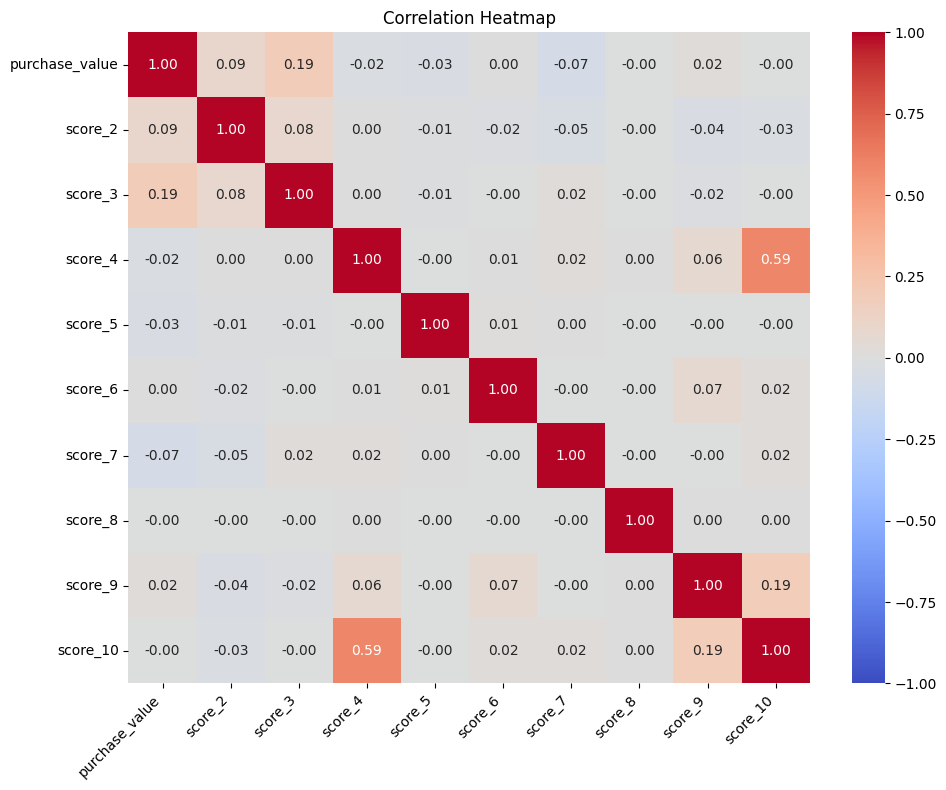

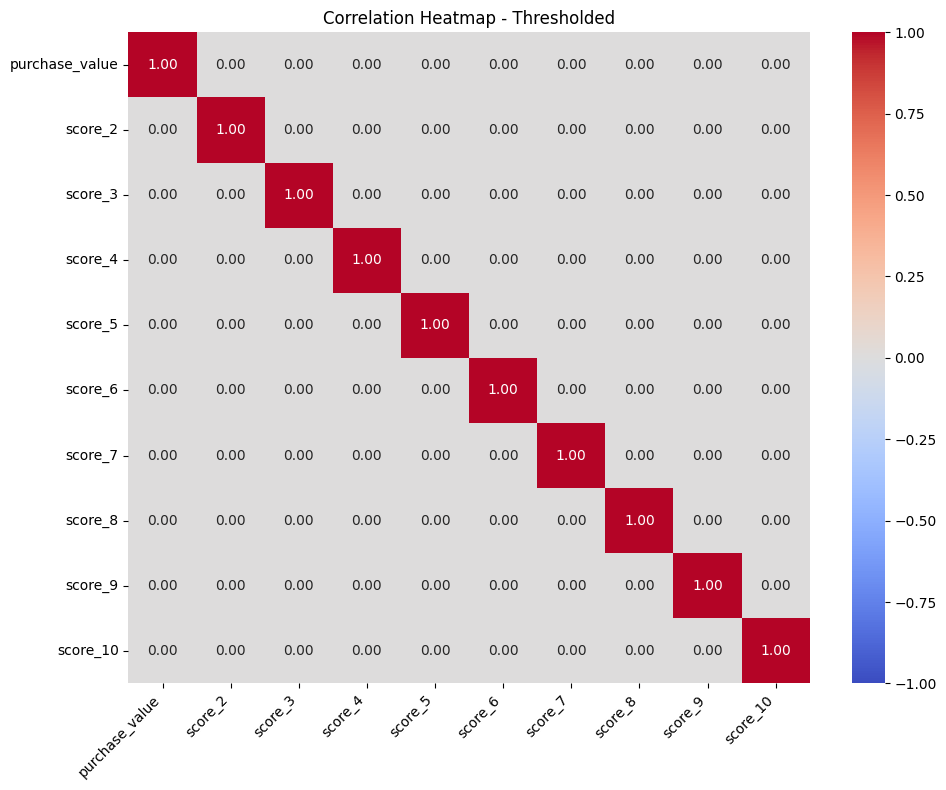

In [15]:
def score_heatmap(corr_mat,title):
    # Create the heatmap
    plt.figure(figsize=(10, 8))  # Set the figure size
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt = "0.2f")

    # Customize the plot
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust the layout

    # Show the plot
    plt.show()

def generate_correlation_heatmaps(df, numerical_cols, pho):
    """
    Generates two correlation heatmaps for the provided DataFrame:
    1. Full correlation heatmap.
    2. Thresholded binary correlation heatmap.

    Args:
        df (DataFrame): The input DataFrame containing numerical columns.
        numerical_cols (list of str): List of numerical column names.
        pho (float): Threshold for binarizing the correlation matrix.

    """
    numerical_df = df[numerical_cols]
    corr_mat = numerical_df.corr()
    score_heatmap(corr_mat, 'Correlation Heatmap')

    # Create the thresholded binary correlation matrix
    corr_mat_bin = corr_mat.apply(lambda x: x.map(lambda val: 1 if val > pho else -1 if val < -pho else 0))

    score_heatmap(corr_mat_bin, 'Correlation Heatmap - Thresholded')


numerical_cols = ['purchase_value', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10'] 
generate_correlation_heatmaps(data, numerical_cols, 0.7)


Assuming a Pearson correlation threshold of 0.7 to identify highly correlated features, the heatmaps above indicate that none of the numerical columns exhibit strong correlations with each other. This suggests that the variables are not redundant and can be retained for further analysis without concerns of multicollinearity.

### 1.5.2 Hypothesis Testing

To evaluate whether fraudulent transactions differ significantly from non-fraudulent ones, I will use the **Mann-Whitney U Test** for continuous variables, as the data does not follow a Gaussian (normal) distribution. For categorical variables, I will use the **Chi-Square test** to assess the association between the categorical variables and fraud.

Key considerations:
- The Mann-Whitney U Test is well-suited for non-normally distributed data and is robust to unequal sample sizes. Although fraudulent transactions represent only 5% of the dataset, the overall sample size is large enough to provide reliable results.
- Given the multiple comparisons across several variables, I will apply the Bonferroni correction to adjust the significance level and reduce the risk of Type I errors.



In [16]:
def perform_hypothesis_tests(data, categorical_cols, numerical_cols, target='fraud', alpha=0.05):
    """
    Performs hypothesis tests on categorical and numerical columns to evaluate their relationship 
    with a target variable (default: 'fraud'). Chi-squared tests are applied to categorical variables,
    and Mann-Whitney U tests are applied to numerical variables. The significance level is adjusted 
    using Bonferroni correction for multiple hypothesis testing.

    Args:
        data (pd.DataFrame): The dataset containing both categorical and numerical variables.
        categorical_cols (list): List of column names representing categorical variables.
        numerical_cols (list): List of column names representing numerical variables.
        target (str, optional): The target column to compare with, default is 'fraud'.
        alpha (float, optional): The significance level for hypothesis testing, default is 0.05.

    Raises:
        ValueError: If invalid data or columns are provided for the hypothesis testing.
    """
    hypothesis_results = {}

    # Categorical Variables
    for col in categorical_cols:
        if col != target:
            contingency_table = pd.crosstab(data[col], data[target])
            hypothesis_results[col] = stats.chi2_contingency(contingency_table)

    # Numerical Variables
    for col in numerical_cols:
        fraud_series = data[data[target] == 1][col]
        non_fraud_series = data[data[target] == 0][col]
        hypothesis_results[col] = stats.mannwhitneyu(fraud_series.dropna(), non_fraud_series.dropna())

    bonferroni_alpha = alpha / len(hypothesis_results)

    print(f"p-value threshold  : {alpha:0.2f}")
    print(f"Bonferroni-adjusted: {bonferroni_alpha:0.3f}\n")

    print(f"{'Feature':<20} | {'Significant':<11} | p-value\n{'-'*47}")
    for col, test_result in hypothesis_results.items():
        p_value = test_result.pvalue
        significant  = p_value < bonferroni_alpha
        print(f"{col:<20} | {str(significant):<11} | {p_value:.3e}" )

    
numerical_cols = ['purchase_value', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10'] 
categorical_cols = ['country', 'doc_sent_1', 'doc_sent_2', 'doc_sent_3', 'product_category', 'score_1']
perform_hypothesis_tests(data, categorical_cols, numerical_cols)

p-value threshold  : 0.05
Bonferroni-adjusted: 0.003

Feature              | Significant | p-value
-----------------------------------------------
country              | True        | 7.758e-63
doc_sent_1           | True        | 0.000e+00
doc_sent_2           | True        | 0.000e+00
doc_sent_3           | True        | 0.000e+00
product_category     | True        | 2.634e-112
score_1              | True        | 2.372e-126
purchase_value       | True        | 5.049e-84
score_2              | True        | 1.190e-66
score_3              | True        | 1.996e-03
score_4              | True        | 5.198e-254
score_5              | True        | 1.751e-27
score_6              | True        | 0.000e+00
score_7              | True        | 1.238e-65
score_8              | False       | 3.525e-01
score_9              | True        | 0.000e+00
score_10             | True        | 0.000e+00


The p-value for the feature `score_8` is greater than the Bonferroni-adjusted p-value threshold, indicating that it does not show a statistically significant difference between fraudulent and non-fraudulent transactions after accounting for multiple comparisons. Retaining features like this, which do not significantly contribute to distinguishing between fraud and non-fraud, can introduce noise to the machine learning model, increasing the risk of overfitting and potentially reducing model performance. Therefore, I will remove this feature from the analysis to improve the model’s accuracy and simplify its structure.

### 1.5.3 Summary

- **Correlation Check**: None of the numerical columns are highly correlated, with all Pearson correlations falling below the 0.7 threshold. This indicates no multicollinearity concerns.
- **Hypothesis Test**: After applying the Bonferroni correction for multiple comparisons, `score_8` did not show a statistically significant difference between fraud and non-fraud transactions and will be removed.


# 2. Machine Learning Application

## 2.1 Variables

Key variables and configurations for the machine learning pipeline are defined here. This includes columns to drop, features to encode (using both one-hot and label encoding), and the list of numerical features. Additionally, a range of machine learning models is specified.

In [17]:
# Variables
def Variables():
    droopcols = ['product','purchase_date','score_fraud_model','score_8'] 
    numerical_feats = [
        'purchase_value', 'score_2', 'score_3', 'score_4',
        'score_5','score_6', 'score_7', 'score_9', 'score_10',
        ]
    encode_onehot = ['country', 'score_1']
    encode = ['product_category']
    categorical_feats = encode_onehot+encode
    
    model_names = {
        'xgboost': 'XGBoost Classifier',
        'lightgbm': 'LightGBM Classifier',
        'catboost': 'CatBoost Classifier',
        'logistic_regression': 'Logistic Regression',
        'random_forest': 'Random Forest Classifier',
        'mlp': 'Multi-layer Perceptron (Neural Network)',
        'decision_tree': 'Decision Tree Classifier',
        'balanced_bagging': 'Balanced Bagging Classifier',
        'easy_ensemble': 'Easy Ensemble Classifier'
    }

    var = {
        
        'tablename': 'fraudclass',
        'engine': create_engine(hiden.alchemy(hiden.secrets())),
        
        'droopcols': droopcols,
        'numerical_feats': numerical_feats,
        'categorical_feats': categorical_feats,
        'encode_onehot': encode_onehot,
        'encode': encode,

        'model_names': model_names,

    }
    return var
    
var = Variables()
data = pd.read_sql_query(f"SELECT * FROM {var['tablename']}", con=var['engine'])    

## 2.2 Support Functions

In [18]:
def normalize_list(x,ntype = 'minmax'):
    """
    Normalizes a list or array of numerical values using the specified method.

    Args:
        x (list or array-like): A list or array of numerical values to be normalized.
        method (str, optional): The normalization method to apply. Defaults to 'minmax'.
            - 'minmax': Scales values between 0 and 1 using min-max scaling.
            - 'log': Applies a logarithmic transformation and then scales values.

    Returns:
        list or array-like: The normalized values.
    """
    match ntype:
        case 'minmax':
            return (x - np.min(x)) / np.max(x)
        case 'log':
            x = np.log(x - np.min(x) + 1)
            return (x / np.max(x))

def cols_bool2int(df):
    """
    Converts boolean columns in a DataFrame to integer columns.

    Args:
        df (pandas.DataFrame): The input DataFrame containing boolean columns.

    Returns:
        pandas.DataFrame: A copy of the DataFrame where all boolean columns 
        have been converted to integer type (True -> 1, False -> 0).
    """

    df = df.copy()
    boolcols = [col for col,dtype in df.dtypes.items() if dtype == bool]
    df[boolcols] = df[boolcols].astype(int)
    return df

def print_mean_std_significant(values):
    if len(values) == 0:
        return "List is empty"
    
    mean = np.mean(values)
    std = np.std(values)
    
    print(f"{mean:.2f} ± {std:.2f}")


## 2.3 Preprocessing

This section outlines the steps taken to preprocess the data for the fraud detection, covering modifications to specific columns, handling missing values, and encoding strategies.

* **Modifications to Specific Columns**:
    * **Country**: All countries other than Brazil (`BR`) and Argentina (`AR`) are classified as `OTHER`.
    * **Product Category**: Only the top 12% of best-selling `product_category` entries, where 80% of fraud cases are concentrated, are retained for analysis.

* **Dropping Unnecessary Columns**: The following columns will be dropped as they are not relevant for the analysis: `product`, `purchase_date`, `score_8`, and `score_fraud_model`.

* **Handling Missing Values**:
    * **Documents**: Missing values in document-related columns (`doc_sent_` columns) are treated as follows: 'Y' is replaced with `1`, 'N' and `NaN` are replaced with `0`. This assumes missing values indicate that the document was not provided.
    * **Score Columns**: Missing values in score-related columns are filled using the median value of the respective column.

* **Normalization**: All numerical features will be normalized to ensure they are on a similar scale.

* **Encoding Categorical Features**:
    * **One-Hot Encoding**: Categorical features will be encoded using one-hot encoding, except for `product_category`.
    * **Label Encoding**: Due to high cardinality, `product_category` will be encoded using `LabelEncoder`.

* **Converting Boolean Columns**: Boolean columns will be transformed from 'True'/'False' values into integer values (`1` for `True` and `0` for `False`).


In [19]:
def preprocess(var,data):
    """
    Preprocesses the input data for fraud detection by applying various transformations.

    Args:
        var (dict): Configuration dictionary for preprocessing steps (e.g., columns to drop,
            features to encode).
        data (pandas.DataFrame): The input dataset to be preprocessed.

    Returns:
        pandas.DataFrame: The cleaned and transformed DataFrame ready for analysis.
    """

    df = data.copy()

    # Country
    df['country'] = df['country'].apply(lambda x: x if x in ['BR', 'AR'] else 'OTHER')

    
    # Product Category
    df_pc = data['product_category'].value_counts().to_frame(name='count')
    df_pc['fraud'] = data[['product_category','fraud']].groupby('product_category').sum()
    df_pc['fraud_pot'] = (df_pc['fraud']/df_pc['fraud'].sum()).cumsum()
    df_pc = df_pc.sort_values(by= 'count',ascending=False)
    
    remain_cats = df_pc[df_pc['fraud_pot']<.8].index.to_list()
    df = df[df['product_category'].isin(remain_cats)]
    
    # Drooping columns
    df.drop(var['droopcols'],axis=1,inplace=True)

    # Missing Values
    
    ## Documents
    doc_cols = [col for col in df.columns if 'doc_sent_' in col]
    for dcol in doc_cols:

        true_mask = df[dcol].isin(['Y'])
        false_mask = (df[dcol].isna()) | df[dcol].isin(['N'])

        df.loc[true_mask,dcol] = 1
        df.loc[false_mask,dcol] = 0
        
        df[dcol] = df[dcol].astype(int)
        
    ## Score Columns
    score_cols = [col for col in var['numerical_feats'] if 'score_' in col]
    df[score_cols] = df[score_cols].apply(lambda x: x.fillna(x.median()))

    # Normalization
    for x in var['numerical_feats']:
        df[x] = normalize_list(df[x])

    # Encoding
    df = pd.get_dummies(df, columns=var['encode_onehot'])
    for enc in var['encode']:
        df[enc] = LabelEncoder().fit_transform(df[enc])

    # Changing boolean coluns
    df = cols_bool2int(df)

    return df

df = preprocess(var,data)
display(df.head())
print('-'*50)
display(df.describe().round(2))

,doc_sent_1,doc_sent_2,doc_sent_3,product_category,purchase_value,score_2,score_3,score_4,score_5,score_6,...,score_9,score_10,fraud,country_AR,country_BR,country_OTHER,score_1_1,score_1_2,score_1_3,score_1_4
0,1,0,0,565,0.001585,0.7685,0.006804,0.40,0.001560,0.000044,...,0.031813,0.045843,0,0,1,0,0,0,0,1
1,1,1,0,400,0.035169,0.7550,0.000667,0.02,0.000000,0.000281,...,0.531283,0.000000,0,0,1,0,0,0,0,1
2,1,0,0,909,0.095701,0.7455,0.017476,0.06,0.000000,0.000178,...,0.235817,0.034607,0,1,0,0,0,0,0,1
3,1,0,1,812,0.000993,0.7631,0.001364,1.00,0.001692,0.000170,...,0.225875,0.515506,0,0,1,0,0,0,0,1
4,1,0,0,431,0.000990,0.7315,0.000413,0.30,0.000000,0.000044,...,0.135870,0.067416,0,0,1,0,0,1,0,0


--------------------------------------------------


,doc_sent_1,doc_sent_2,doc_sent_3,product_category,purchase_value,score_2,score_3,score_4,score_5,score_6,...,score_9,score_10,fraud,country_AR,country_BR,country_OTHER,score_1_1,score_1_2,score_1_3,score_1_4
count,109394.0,109394.00,109394.00,109394.00,109394.00,109394.00,109394.00,109394.00,109394.0,109394.0,...,109394.00,109394.00,109394.00,109394.00,109394.0,109394.00,109394.00,109394.00,109394.00,109394.00
mean,0.9,0.16,0.55,493.37,0.01,0.74,0.02,0.43,0.0,0.0,...,0.30,0.13,0.05,0.17,0.8,0.03,0.03,0.08,0.02,0.88
std,0.3,0.37,0.50,287.93,0.02,0.12,0.06,0.40,0.0,0.0,...,0.23,0.14,0.23,0.38,0.4,0.16,0.17,0.26,0.12,0.33
min,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
25%,1.0,0.00,0.00,251.00,0.00,0.70,0.00,0.04,0.0,0.0,...,0.11,0.02,0.00,0.00,1.0,0.00,0.00,0.00,0.00,1.00
50%,1.0,0.00,1.00,489.00,0.01,0.76,0.00,0.28,0.0,0.0,...,0.25,0.08,0.00,0.00,1.0,0.00,0.00,0.00,0.00,1.00
75%,1.0,0.00,1.00,747.00,0.01,0.81,0.01,1.00,0.0,0.0,...,0.44,0.20,0.00,0.00,1.0,0.00,0.00,0.00,0.00,1.00
max,1.0,1.00,1.00,995.00,1.00,1.00,1.00,1.00,1.0,1.0,...,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00


## 2.4 Choosing a model

In this part, I select and train various machine learning models to identify the best-performing approach for fraud detection. The models range from simple classifiers, like Logistic Regression, to more complex ensemble methods, such as XGBoost and Easy Ensemble, which are particularly useful for imbalanced datasets like ours. 

To handle the imbalance between fraudulent and non-fraudulent transactions, I apply specific strategies such as class weighting (e.g., `class_weight='balanced'`) or using techniques like `scale_pos_weight` in XGBoost to ensure the model pays sufficient attention to the minority fraud class.

The performance of each model is evaluated using stratified 5-fold cross-validation, and the primary evaluation metric is the ROC-AUC score, which is suitable for imbalanced classification tasks. Additionally, I measure the computation time for each model to assess its efficiency.

In [20]:
def train_model(model_name, imbalance_ratio=None):
    """
    Trains a machine learning model based on the selected model name using a match statement.

    Args:
        model_name (str): Name of the model to train ('xgboost', 'lightgbm', 'catboost', 'logistic_regression', etc.)
        imbalance_ratio (float, optional): Imbalance ratio for models that require it.

    Returns:
        Trained model instance.
    """
    match model_name:
        case 'xgboost':
            model = XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42)
        case 'lightgbm':
            model = LGBMClassifier(is_unbalance=True, random_state=42,verbosity=-1)
        case 'catboost':
            model = CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_seed=42)
        case 'logistic_regression':
            model = LogisticRegression(class_weight='balanced', max_iter=int(5e3), random_state=42)
        case 'random_forest':
            model = RandomForestClassifier(class_weight='balanced', random_state=42)
        case 'svm':
            model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)  # Enable probability for ROC and Precision-Recall curves
        case 'mlp':
            model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
        case 'decision_tree':
            model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
        case 'balanced_bagging':
            model = BalancedBaggingClassifier(random_state=42)
        case 'easy_ensemble':
            model = EasyEnsembleClassifier(random_state=42)
        case _:
            raise ValueError(f"Model {model_name} not recognized. Please choose a valid model.")
    
    return model

def evaluate_models(models, X, y):
    """
    Perform stratified K-Fold cross-validation on multiple models to assess their performance on the fraud dataset, using ROC-AUC as the evaluation metric.
    
    Args:
        models: A dictionary mapping model names to titles.
        X: A pandas DataFrame containing the feature variables.
        y: A pandas Series containing the target variable (fraud).
    
    Raises:
        KeyError: If a model name is missing from the dictionary.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    imbalance_ratio = float(np.sum(y == 0)) / np.sum(y == 1)

    for model_name, title in models.items():
        start_time = time.time()
        print(f"> {title}")

        model = train_model(model_name, imbalance_ratio)
        scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
        print(f"--> Mean Cross-Validation ROC-AUC Score: ", end='')
        print_mean_std_significant(scores)

        elapsed_time = time.time() - start_time
        print(f"--> Time taken: {elapsed_time:.0f} seconds ({elapsed_time/60:.2f} minutes)")


# Feature and target variables
X = df.drop(columns=['fraud'])
y = df['fraud']

evaluate_models(var["model_names"], X, y)

> XGBoost Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.77 ± 0.01
--> Time taken: 2 seconds (0.03 minutes)
> LightGBM Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.79 ± 0.01
--> Time taken: 1 seconds (0.02 minutes)
> CatBoost Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.78 ± 0.01
--> Time taken: 40 seconds (0.66 minutes)
> Logistic Regression
--> Mean Cross-Validation ROC-AUC Score: 0.76 ± 0.01
--> Time taken: 49 seconds (0.82 minutes)
> Random Forest Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.77 ± 0.01
--> Time taken: 60 seconds (0.99 minutes)
> Multi-layer Perceptron (Neural Network)
--> Mean Cross-Validation ROC-AUC Score: 0.75 ± 0.02
--> Time taken: 30 seconds (0.50 minutes)
> Decision Tree Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.57 ± 0.00
--> Time taken: 4 seconds (0.06 minutes)
> Balanced Bagging Classifier
--> Mean Cross-Validation ROC-AUC Score: 0.75 ± 0.01
--> Time taken: 4 seconds (0.07 minutes)
> Easy Ensemble Classifier
--> 

Given the results from cross-validation, where LightGBM achieved the highest mean ROC-AUC score (0.79 ± 0.01) and had one of the fastest computation times, I will proceed with LightGBM for hyperparameter tuning. LightGBM is particularly suited for this imbalanced dataset due to its speed and efficiency, as well as its ability to handle large amounts of data with minimal overfitting.

The next step involves tuning the LightGBM model using Randomized Search to optimize its performance further. The Randomized Search will explore a wide range of hyperparameters, and the best configuration will be selected based on the ROC-AUC score.


In [21]:
def tune_lgbm_model(X, y):
    """
    Perform Randomized Search on LightGBM Classifier with hyperparameter tuning and ROC-AUC evaluation.

    Args:
        X: Feature matrix as a pandas DataFrame.
        y: Target variable as a pandas Series.

    Returns:
        best_params: Best found hyperparameters.
        best_score: Best ROC-AUC score.

    Raises:
        ValueError: If fitting or validation fails.
    """
    
    param_grid = {
        'num_leaves': randint(20, 150),
        'max_depth': randint(-1, 10),
        'learning_rate': uniform(0.05, 0.5),
        'n_estimators': randint(100, 1000),
        'min_data_in_leaf': randint(20, 150),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    model = LGBMClassifier(is_unbalance=True, random_state=42, verbosity=-1)

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='roc_auc',
        n_iter=200,
        cv=4,
        verbose=1,
        random_state=42
    )

    random_search.fit(X, y)
    return random_search.best_params_, random_search.best_score_

best_params, best_score = tune_lgbm_model(X, y)

# Get the best hyperparameters and score
print("Best Hyperparameters: ", best_params)
print("Best Score: ", best_score)


Fitting 4 folds for each of 200 candidates, totalling 800 fits
Best Hyperparameters:  {'learning_rate': 0.06827483392404744, 'max_depth': 6, 'min_data_in_leaf': 38, 'n_estimators': 117, 'num_leaves': 20, 'reg_alpha': 0.7755276166950106, 'reg_lambda': 0.4532888347480276}
Best Score:  0.7899774050620231


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_lgbm_model = LGBMClassifier(**best_params, is_unbalance=True, random_state=42)
best_lgbm_model.fit(X_train, y_train)

y_pred = best_lgbm_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     20679
           1       0.14      0.66      0.22      1200

    accuracy                           0.75     21879
   macro avg       0.56      0.71      0.54     21879
weighted avg       0.93      0.75      0.82     21879

ROC-AUC: 0.7844739429695183
Precision-Recall AUC: 0.2873146850612981
Log-Loss: 9.0294


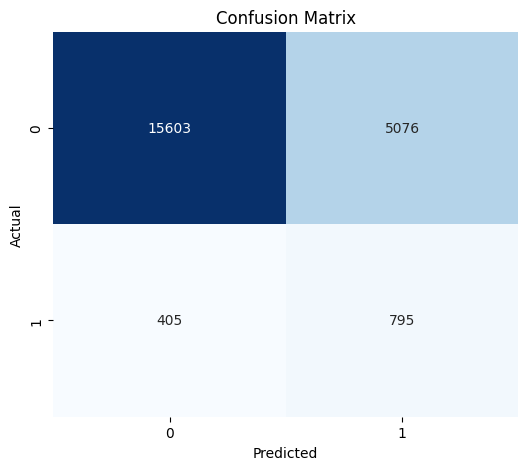

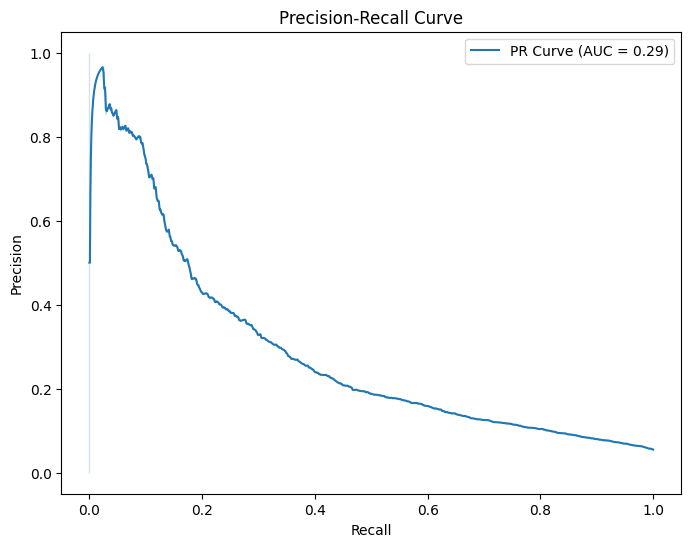

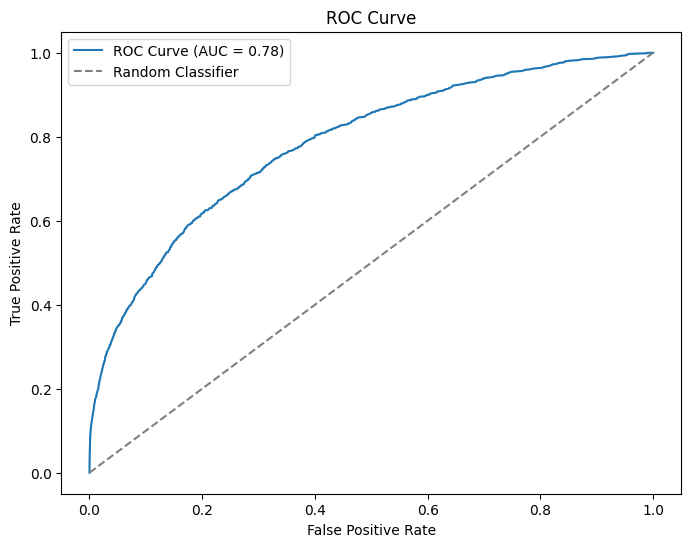

In [29]:
def model_performance_metrics(model, X_test, y_test, y_pred):
    """
    Evaluates model performance using Precision, Recall, F1-Score, ROC-AUC, Precision-Recall Curve, and Confusion Matrix.

    Args:
        model: Trained machine learning model.
        X_test (pd.DataFrame): Test feature data.
        y_test (pd.Series): True labels for the test set.
        y_pred (np.array): Predicted labels from the model.

    Raises:
        ValueError: If the model does not support probability predictions or decision function.
    """
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Verify model prediction method
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        raise ValueError("The model does not support probability prediction or decision function.")
    
    # Display performance metrics
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob)}")
    
    # Precision-Recall AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_vals, precision_vals)
    print(f"Precision-Recall AUC: {pr_auc}")
    
    # Log-Loss
    logloss = log_loss(y_test, y_pred)
    print(f"Log-Loss: {logloss:.4f}")

    # Plotting functions
    plot_confusion_matrix(y_test, y_pred)
    plot_precision_recall_curve(precision_vals, recall_vals, pr_auc)
    plot_roc_curve(y_test, y_prob, roc_auc_score(y_test, y_prob))

def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(6, 5))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_precision_recall_curve(precision_vals, recall_vals, pr_auc):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=recall_vals, y=precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

def plot_roc_curve(y_test, y_prob, roc_auc):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

model_performance_metrics(best_lgbm_model, X_test, y_test, y_pred)


Approval Rate: 73%
Initial Fraud Rate: 5%
Final Fraud Rate: 2%
Fraud Detection Rate: 66%
--------------------------------------------------
Money Saved: 82% (73,054.29 saved out of 88,889.38 originally lost)


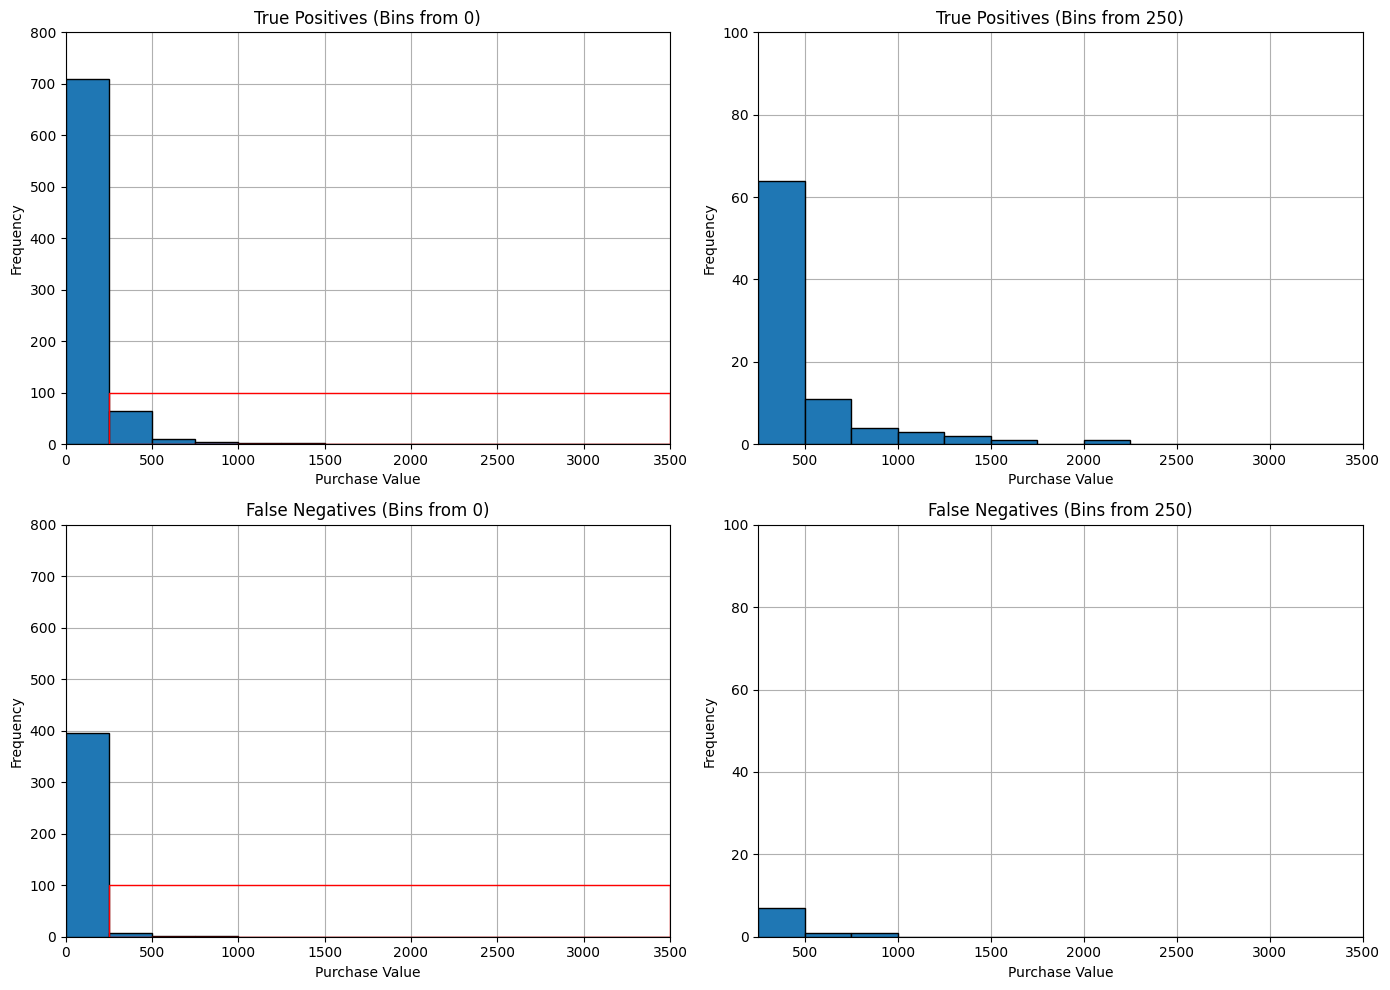

In [24]:
def print_fraud_detection_stats(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    total_transactions = conf_matrix.sum()
    
    approval_rate = (tn + fn) / total_transactions
    initial_fraud_rate = (fn + tp) / total_transactions
    final_fraud_rate = fn / total_transactions
    detection_rate = tp / (fn + tp)

    print(f"Approval Rate: {approval_rate * 100:.0f}%")
    print(f"Initial Fraud Rate: {initial_fraud_rate * 100:.0f}%")
    print(f"Final Fraud Rate: {final_fraud_rate * 100:.0f}%")
    print(f"Fraud Detection Rate: {detection_rate * 100:.0f}%")

def calculate_savings_percentage(X_test, y_test, y_pred, data):
    
    X_test = X_test.copy()

    # Add y_pred and y_test to the test set
    X_test['y_pred'] = y_pred
    X_test['y_test'] = y_test

    # Identify True Positives and False Negatives
    true_positives = X_test[(X_test['y_pred'] == 1) & (X_test['y_test'] == 1)]
    false_negatives = X_test[(X_test['y_pred'] == 0) & (X_test['y_test'] == 1)]

    # Fetch purchase values for True Positives and False Negatives
    true_positive_purchase_values   = data.loc[true_positives.index, 'purchase_value']
    false_negatives_purchase_values = data.loc[false_negatives.index, 'purchase_value']
    tp_total = true_positive_purchase_values.sum()
    fn_total = false_negatives_purchase_values.sum()

    # Total lost amount (True Positives + False Negatives)
    total_lost = tp_total + fn_total

    # Percentage of money saved
    money_saved = 100 * tp_total / total_lost

    # Print results
    print(f"Money Saved: {money_saved:.0f}% ({tp_total:,.2f} saved out of {total_lost:,.2f} originally lost)")
    
    plot_fraud_purchase_histograms(true_positive_purchase_values, false_negatives_purchase_values, data, bin_size=250)

def plot_fraud_purchase_histograms(true_pos_values, false_neg_values, data, bin_size=250):
    """
    Plots histograms for true positive and false negative purchase values from fraud detection data.

    Args:
        true_pos_values (list or array-like): The purchase values for true positive cases.
        false_neg_values (list or array-like): The purchase values for false negative cases.
        data (pandas.DataFrame): The dataset containing fraud information and purchase values.
        bin_size (int, optional): The size of the bins for the histograms. Defaults to 250.

    Raises:
        ValueError: If there is an issue with the input data.
    """

    # Get fraud purchase values and calculate the upper limit for the bins
    fraud_values = data[data['fraud'] == 1]['purchase_value']
    max_value = (int(np.max(fraud_values) // bin_size) + 1) * bin_size
    
    # Set up the figure and subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    bins_range = range(0, max_value + bin_size, bin_size)

    # Helper function for repeated plot logic
    def plot_histogram(ax, values, bins, title, xlim, ylim=None):
        ax.hist(values, bins=bins, edgecolor='black', zorder=3)
        ax.set_title(title)
        ax.set_xlabel('Purchase Value')
        ax.set_ylabel('Frequency')
        ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.grid(True, zorder=0)

    # Plot histograms for true positive and false negative values
    plot_histogram(axs[0, 0], true_pos_values,  bins_range,     'True Positives (Bins from 0)', (0, max_value))
    plot_histogram(axs[0, 1], true_pos_values,  bins_range[1:], f'True Positives (Bins from {bin_size})', (bin_size, max_value), (0, 100))
    plot_histogram(axs[1, 0], false_neg_values, bins_range,     'False Negatives (Bins from 0)', (0, max_value))
    plot_histogram(axs[1, 1], false_neg_values, bins_range[1:], f'False Negatives (Bins from {bin_size})', (bin_size, max_value), (0, 100))
    
    # Compute max frequency for consistent y-limits across relevant plots
    max_freq = max(np.histogram(true_pos_values, bins=bins_range)[0].max(), 
                   np.histogram(false_neg_values, bins=bins_range)[0].max())
    y_limit = (0, (max_freq // 100 + 1) * 100)
    
    axs[0, 0].set_ylim(y_limit)
    axs[1, 0].set_ylim(y_limit)

    # Add a red rectangle to Plot 1 and Plot 3
    for ax in [axs[0, 0], axs[1, 0]]:
        rect = patches.Rectangle((bin_size, 0), max_value - bin_size, 100, linewidth=1, edgecolor='r', facecolor='none', zorder=4)    
        ax.add_patch(rect)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

print_fraud_detection_stats(y_test, y_pred)
print('-'*50)
calculate_savings_percentage(X_test, y_test, y_pred, data)

After tuning the LightGBM model using Randomized Search, we achieved a best ROC-AUC score of 0.78. The following performance metrics and insights were obtained from the model's evaluation on the test set:

#### Key Metrics:
- **ROC-AUC**: 0.78 — indicating a good ability to separate fraudulent and non-fraudulent transactions.
- **Log-Loss**: 9.0294 — while relatively high, this reflects the model's challenge in predicting probabilities accurately, especially in the context of an imbalanced dataset. However, this can be further improved with probability calibration techniques or additional tuning.
- **Precision-Recall AUC**: 0.29 — underscoring the complexity of achieving high performance on both precision and recall in this imbalanced dataset.
- **Classification Report**:
  - Fraud (Class 1) had a **Precision** of 0.14, **Recall** of 0.66, and **F1-Score** of 0.22, reflecting the difficulty in predicting fraud accurately.
  - Non-Fraud (Class 0) showed much better performance with a **Precision** of 0.97 and **Recall** of 0.75.


#### Business Impact:
- **Approval Rate**: 73%
- **Initial Fraud Rate**: 5%
- **Final Fraud Rate**: 2%
- **Fraud Detection Rate**: 66%
- **Money Saved**: 82% (approx. $73,054 saved out of $88,889 in total potential fraud loss)


#### Visual Insights:
- **Precision-Recall Curve**: Demonstrates the trade-off between precision and recall, with a Precision-Recall AUC of 0.29, indicating that recall drops quickly as precision increases.
- **ROC Curve**: A robust ROC-AUC of 0.78 shows good separation between fraud and non-fraud cases.
- **Fraud Detection Histograms**:
  - True Positives and False Negatives were plotted across different purchase values, highlighting that the model is robust to identify high value frauds.



### General Thoughts on the ML Implementation
The machine learning implementation successfully tackled the challenge of detecting fraud in an imbalanced dataset. By leveraging techniques such as class weighting, hyperparameter tuning, and cross-validation, the models were optimized to deliver reliable results. LightGBM emerged as the best-performing classifier, balancing efficiency and accuracy. Additionally, there's room for further improvement, particularly in reducing false positives and enhancing precision for fraudulent transactions. Future analyses can benefit from advanced tools like SHAP to further enhance feature engineering, while additional tuning could improve recall for fraudulent transactions. 

### Financial Performance
The model demonstrated significant financial value by reducing the fraud rate from 5% to 2%, saving approximately 82% of potential losses. Despite the higher occurrence of low-value fraud cases, the model efficiently targeted high-value fraudulent transactions, which have a much larger financial impact. By focusing on these critical areas, the model has the potential to greatly reduce financial losses, safeguarding profitability and demonstrating the direct business impact of an effective fraud detection system.

### Final Considerations
The combination of strong performance metrics and favorable financial outcomes underscores the strategic value of implementing this trained model for optimizing operations and maximizing profits. By reducing fraud rates and safeguarding a company’s revenue streams, this model offers a powerful tool for enhancing profitability while minimizing financial risk. 

